In [1]:
from matplotlib import pyplot
import cv2
import imagehash
import os

path = '/home/strider/Code/robotron/resources/images/'
spriteDefFile = open(path+'robotronsprites.txt', 'r')
spriteClasses = open(path+'robotronclasses.txt', 'r')
spriteSheet = cv2.imread(path+"robotronsprites.jpg")
ssh, ssw, _ = spriteSheet.shape
x = 0
y = 0

classes = {}
for line in spriteClasses:
    (name, classname) = line.split()
    classes[classname] = name
    
sprites = {}
spriteClasses = {}
rowheight = 0
i = 0
for line in spriteDefFile:
    i += 1
    (name, c, sid, w, h, _) = line.split()
    w = int(w) * 4
    h = int(h) * 2
    if x + w > ssw:
        x = 0
        y += rowheight + 10
        rowheight = 0
    sprite = spriteSheet[y:y+h, x:x+w]
    sprites[name] = sprite[:,:,::-1]
    spriteClasses[name] = c
    x += w + 10
    if h > rowheight:
        rowheight = h
        
X_test = []
X_name = []
for name in sprites.keys():
    sprite = sprites[name]
    cls = spriteClasses[name]
    if cls == '0':
        continue
    gray = cv2.cvtColor(sprite, cv2.COLOR_BGR2GRAY)
    #hist = lbp_hist(gray)
    X_test.append(gray)
    X_name.append(name)

In [2]:
# Local Binary Pattern function
from skimage.feature import local_binary_pattern
# To calculate a normalized histogram 
from scipy.stats import itemfreq
from sklearn.preprocessing import normalize
import numpy as np
from moviepy.editor import VideoFileClip

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
# http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html
radius = 2
n_points = 8 * radius


def kullback_leibler_divergence(p, q):
    p = np.asarray(p)
    q = np.asarray(q)
    filt = np.logical_and(p != 0, q != 0)
    return np.sum(p[filt] * np.log2(p[filt] / q[filt]))

def match(img):
    best_score = 10
    best_name = None
    lbp = local_binary_pattern(img, n_points, radius, 'uniform')
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))
    results = []
    for name, ref in zip(X_name, X_test):
        ref_hist, _ = np.histogram(ref, density=True, bins=n_bins, range=(0, n_bins))
        score = kullback_leibler_divergence(hist, ref_hist)
        results.append((name, round(score, 3)))
    results = sorted(results, key=lambda score: score[1])
    return results

In [4]:
def process(frame):
    frame = cv2.resize(frame, (1280, 720))
    crop = frame[115:608, 309:975]
    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(gray,10,255,0)
    blur = cv2.GaussianBlur(thresh, (3, 3), 0)
    contours, hierarchy = cv2.findContours(blur, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    fig=pyplot.figure(figsize=(32, 90))
    i = 0
    r = 10
    c = int(len(sprites) / 10) + 1
    for contour in enumerate(contours):       
        (x,y,w,h) = cv2.boundingRect(contour[1])
        if h < 10 or h > 415 or w < 5 or w > 145:
            continue
        sprite = gray[y:y+h, x:x+w]
        x += 309
        y += 115
        cv2.rectangle(frame, (x,y), (x+w,y+h), (255, 255, 255), 2)
        guess = match(sprite)
        i += 1
        print(i, guess[:2])
        subplot = fig.add_subplot(c, r, i)
        pyplot.imshow(sprite, cmap='gray')
        subplot.set_title(i)
        
        cv2.putText(frame, "Class: {}".format(guess[0]), (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    return frame

1 [('electrode13', -0.046), ('sphereoid8', -0.031)]
2 [('electrode13', -0.256), ('electrode9', -0.225)]
3 [('electrode9', -0.062), ('electrode13', -0.028)]
4 [('electrode9', -0.254), ('sphereoid8', -0.229)]
5 [('electrode13', -0.228), ('sphereoid8', -0.112)]
6 [('electrode9', -0.298), ('sphereoid8', -0.271)]
7 [('electrode9', -0.425), ('electrode5', -0.386)]
8 [('electrode13', -0.371), ('electrode7', -0.359)]
9 [('electrode9', -0.326), ('electrode13', -0.267)]
10 [('electrode9', -0.404), ('electrode15', -0.361)]
11 [('electrode9', -0.307), ('enforcer1', -0.288)]
12 [('electrode13', -0.26), ('electrode9', -0.259)]
13 [('electrode9', -0.289), ('electrode13', -0.207)]
14 [('electrode9', -0.338), ('electrode5', -0.27)]
15 [('electrode9', -0.302), ('electrode13', -0.221)]
16 [('electrode9', -0.319), ('electrode15', -0.3)]
17 [('electrode9', -0.355), ('electrode5', -0.305)]
18 [('electrode9', -0.276), ('electrode13', -0.217)]
19 [('electrode9', -0.344), ('sphereoid8', -0.292)]
20 [('electrod

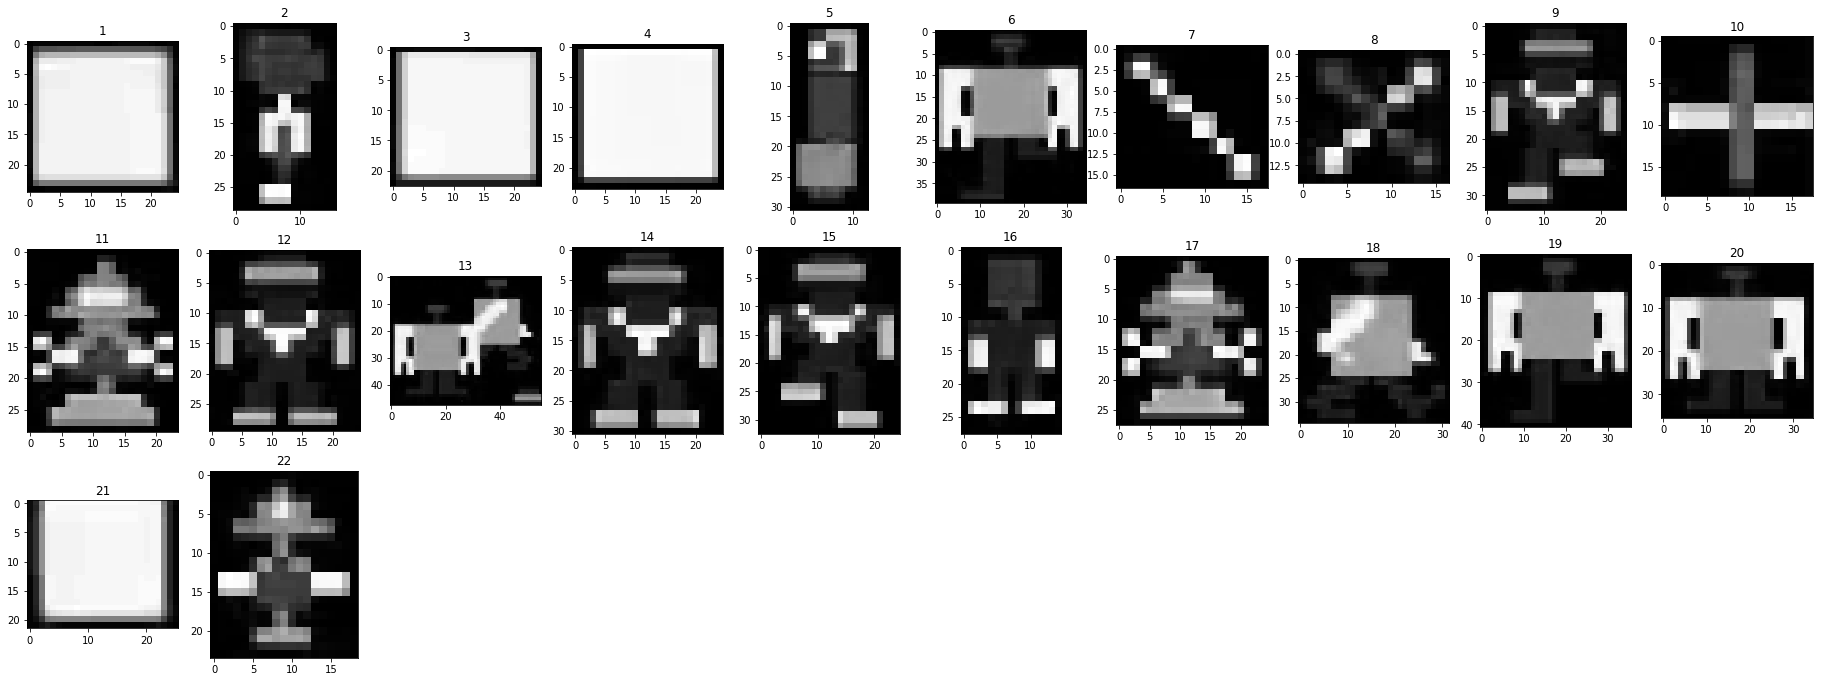

In [5]:
clip = VideoFileClip('/home/strider/Code/robotron/resources/video/robotron-1.mp4')
img = clip.get_frame(101.6)
pyplot.rcParams['figure.figsize'] = [24, 16]
im = process(img)

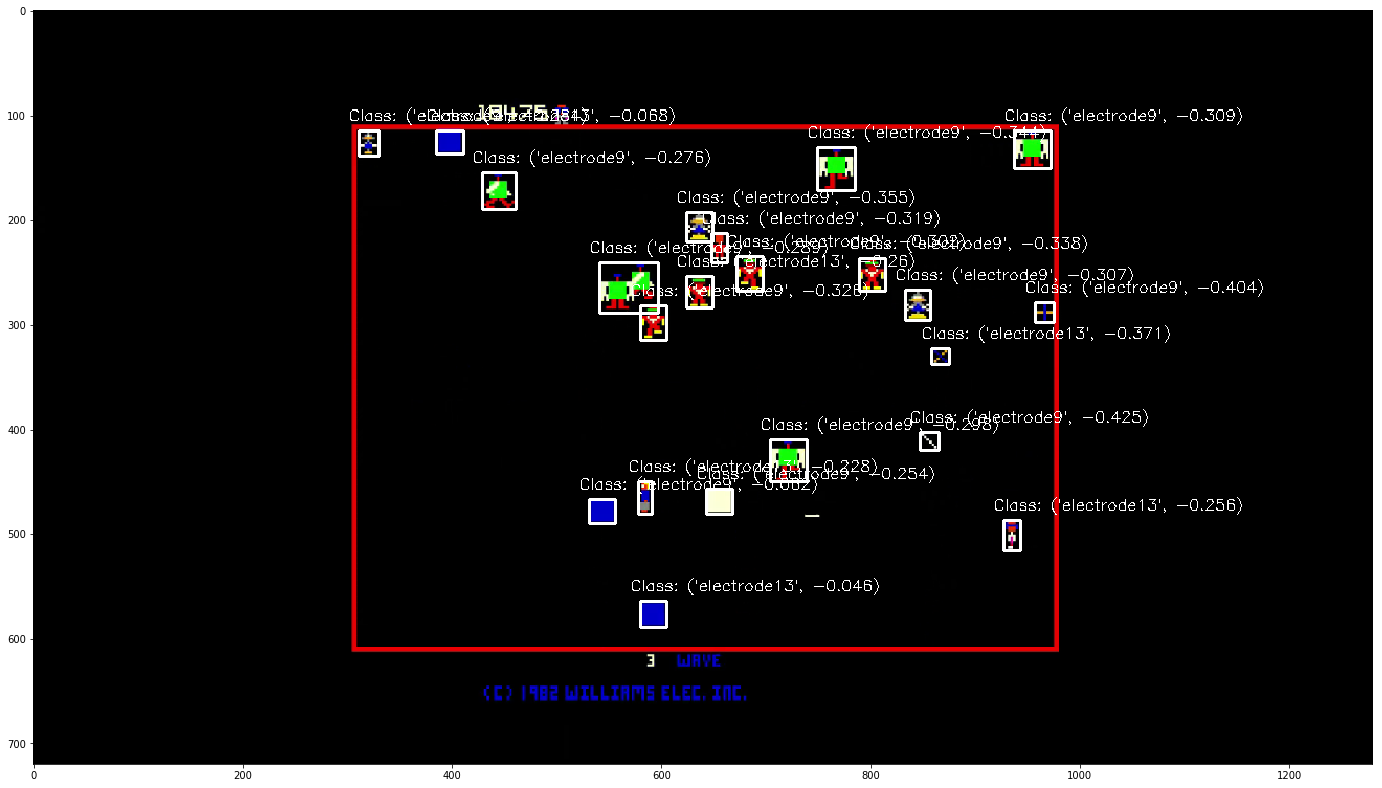

In [6]:
pyplot.imshow(im)

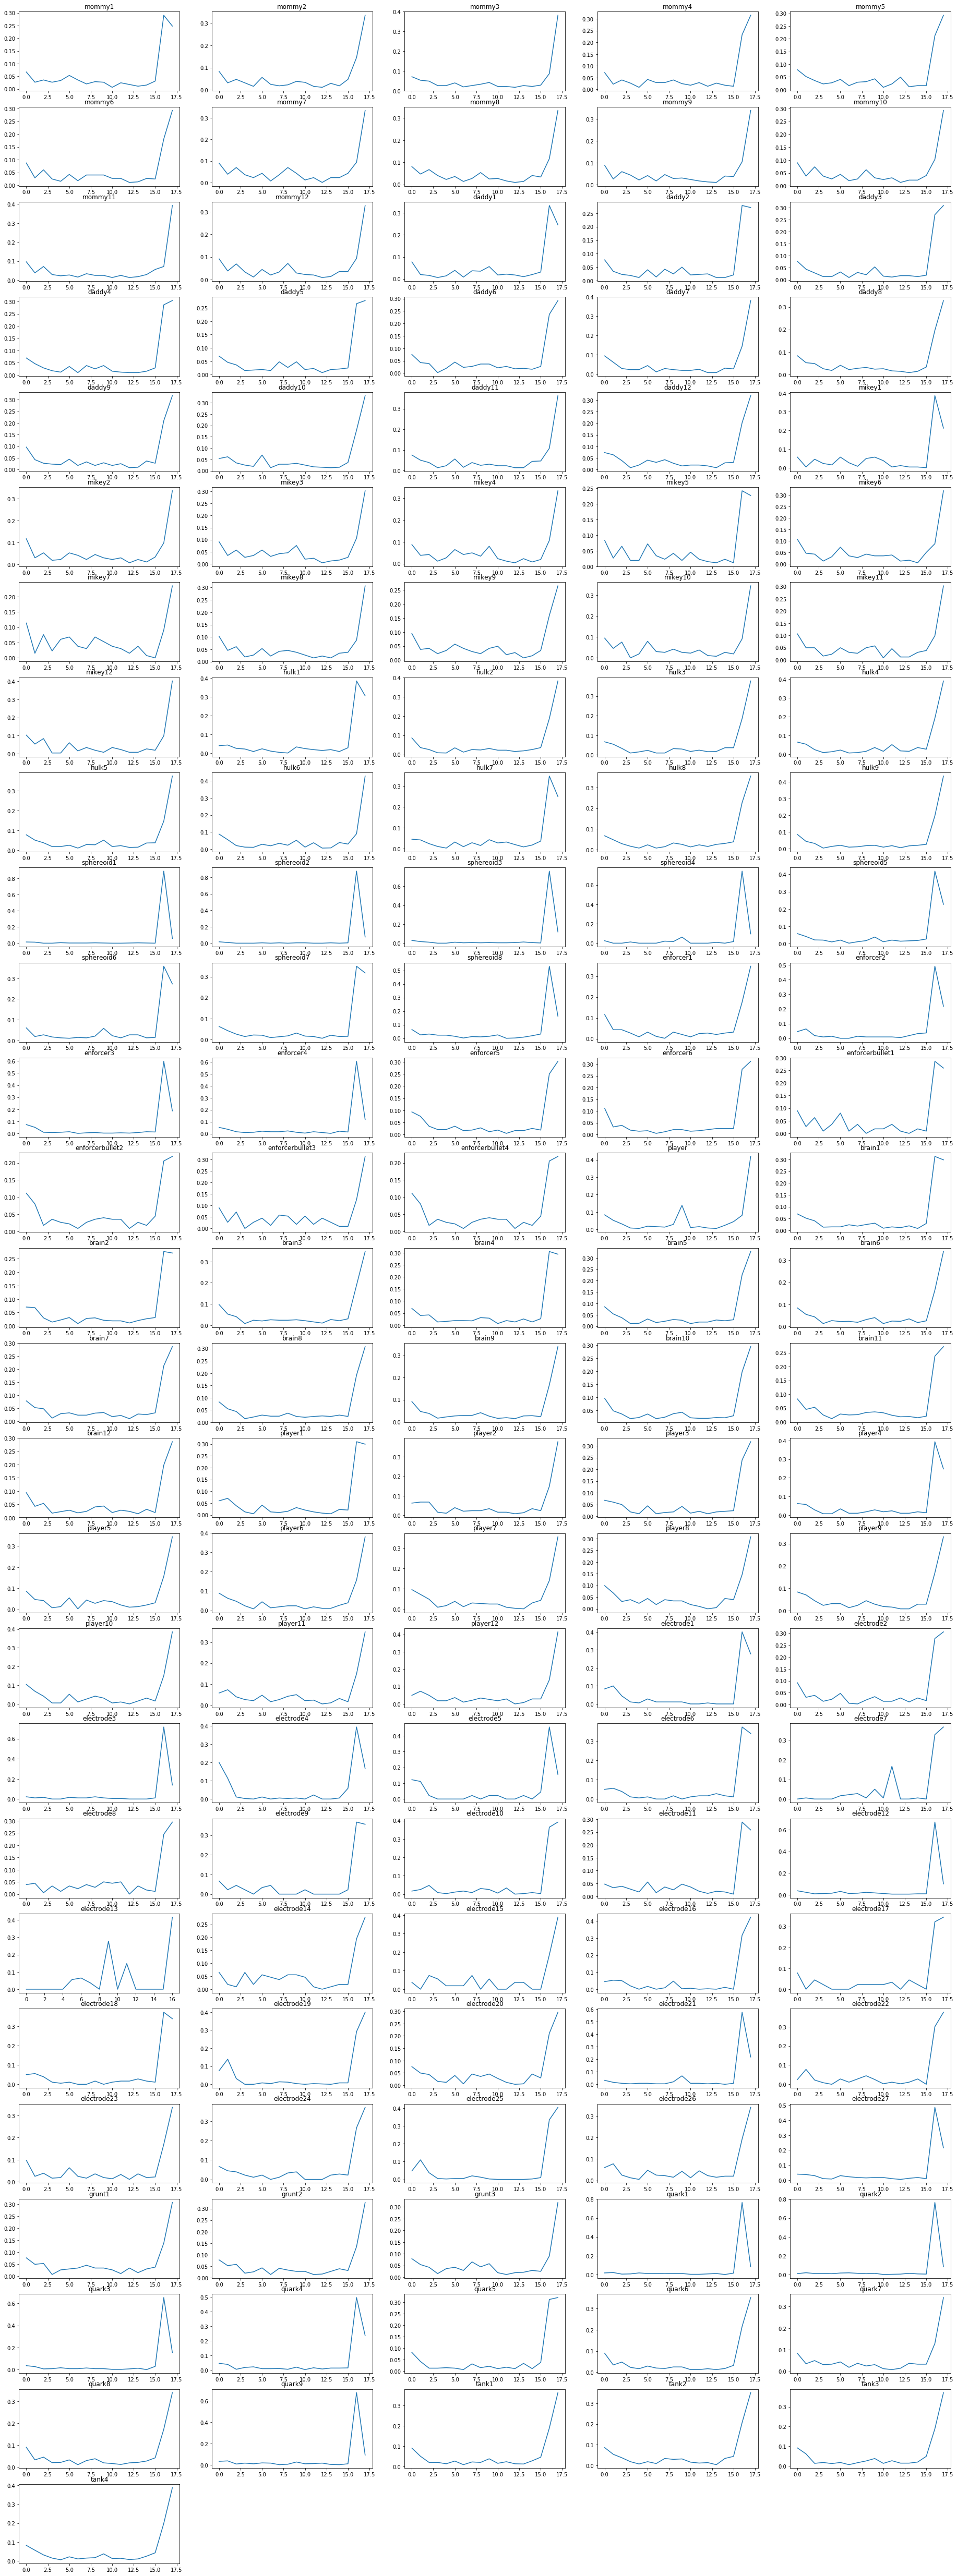

In [13]:
    fig=pyplot.figure(figsize=(32, 90))
    i = 0
    r = 5
    c = int(len(X_test) / r) + 1
    for img, name in zip(X_test, X_name):
        i += 1
        lbp = local_binary_pattern(img, n_points, radius, 'uniform')
        n_bins = int(lbp.max() + 1)
        hist, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))
        subplot = fig.add_subplot(c, r, i)
#         pyplot.imshow(img, cmap="gray")
        pyplot.plot(hist)
        subplot.set_title(name)
#         print(name, hist)
